# A prototype model for a metalworking enterprise

# Project goal

Prepare a prototype of a machine learning model that predicts the recovery rate of gold from gold ore.

The project is made for a company that develops solutions for the efficient operation for the gold mining industry.
The end result of the project is development of a prototype model that predicts the recovery factor of gold from gold-bearing ore.
This model will be used to help optimize production and avoid launching enterprises with unprofitable characteristics.

# Task description

When the mined ore undergoes primary processing, a crushed mixture is obtained. It is sent for flotation (enrichment) and two-stage cleaning. This is how gold ore is recovered from mined ore.

1. **Flotation**

A mixture of gold-bearing ore is fed into the flotation plant. After enrichment, a rough concentrate and “waste tailings” are obtained — product residues with a low concentration of valuable metals.
The stability of this process is affected by the unstable and non-optimal physico-chemical state of the flotation pulp (a mixture of solid particles and liquid).

2. **Cleaning**

The crude concentrate goes through two purifications. The output is the final concentrate and new final tailings.

# Data description

**Technological process**

- Rougher feed - initial raw material
- Rougher additions - flotation reagents: Xanthate, Sulphate, Depressant
- Xanthate ** - xanthate (promoter, or flotation activator);
- Sulphate - sulfate (in this production, sodium sulfide);
- Depressant - depressant (sodium silicate).
- Rougher process - flotation
- Rougher tails
- Float banks - flotation unit
- Cleaner process - cleaning
- Rougher Au - crude gold concentrate
- Final Au - final gold concentrate

**Stage parameters**

- air amount — air volume
- fluid levels - fluid level
- feed size - feed granule size
- feed rate — feed rate

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 100)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

# First look at the data

In [2]:
df_train = pd.read_csv('C:/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('C:/datasets/gold_recovery_test_new.csv')
df_full = pd.read_csv('C:/datasets/gold_recovery_full_new.csv')

In [3]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Found some missing data that will need to be explored. If necessary I should cast the date column to the datetime type

In [5]:
df_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

In [6]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

Due to the nature of the task some parameters are not available because they are measured and / or calculated much later in the development process. Because of this, some features that are present in the train set are missing in the test set. 

Thus, it is necessary to check what features are absent in the test set.

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [8]:
df_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

In [9]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [10]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [11]:
df_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438

# Diving deeper into the data

## Check that the gold recovery coefficient is calculated correctly

Let's double check that the gold recovery coefficient is calculated correctly in this data set. It would be pretty upsetting to learn that the target variable wasn't calculated correctly after I've trained the models on it.

To do the check i will calculate the recovery coefficient for the training sample and compare my calculations and the existing feature using MAE.

In [12]:
def recovery(gold_part_after, gold_part_before, gold_part_left):
    """
    Calculate gold recovery coefficient

    Keyword arguments:
    gold_part_after -- fraction of gold in ore after flotation / refining 
    gold_part_before -- fraction of gold before flotation / refining 
    gold_part_left  — fraction of gold left in tailings after flotation / refining

    """

    recovery_coefficient = (gold_part_after*(gold_part_before-gold_part_left)) / \
        (gold_part_before*(gold_part_after-gold_part_left)) * 100

    return recovery_coefficient

In [13]:
columns = ['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']

In [14]:
calculated_recovery = \
    df_train[columns].apply(lambda x: recovery(x['rougher.output.concentrate_au'],
                                               x['rougher.input.feed_au'],
                                               x['rougher.output.tail_au']), axis=1)

In [15]:
mean_absolute_error(df_train['rougher.output.recovery'], calculated_recovery)

9.73512347450521e-15

The error is almost non existing, I can trust the existing calculations

## Taking closer look at the features not available in the test set

In [16]:
parameters = []

for i in list(df_full.columns): 
    if i not in list(df_test.columns):
        parameters.append(i)

In [17]:
parameters

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
<font color='green'><br>
В общем, да, 
В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, т.к. их невозможно получить/измерить во время выполнения технологического процесса. 

The test sample is missing the values that my model will predict: rougher.output.recovery and final.output.recovery. In addition all the parameters required to calculate the recovery metric (ending with .output) for all substances are missing, which is also quite understandable - these data points won't be available at the time of the model prediction.

There are also missing data in some columns starting with rougher.calculation: seems like during flotation procedure it is not possible to get the calculations coming from flotation units 10 and 11 about the supply of sulfate.

I will exclude these features from the training set, since they will not be available at the time the model is running.
The only thing I will leave in the training dataset are the parameters rougher.output.recovery and final.output.recovery - the target variables.

In [18]:
parameters.remove('rougher.output.recovery')
parameters.remove('final.output.recovery')

In [19]:
df_train = df_train.drop(parameters,  axis=1)

In [20]:
df_train.shape

(14149, 55)

In [21]:
df_test.shape

(5290, 53)

All right, train and test sets have the same set of features now. Let's clean this mess now.

# Data cleaning

## Missing values

In [22]:
df_train = df_train.drop('date', axis = 1)

In [23]:
df_test = df_test.drop('date', axis = 1)

In [24]:
df_train.isna().sum().sort_values(ascending = False).head(20)

rougher.state.floatbank10_e_air             436
rougher.input.floatbank11_xanthate          428
secondary_cleaner.state.floatbank2_a_air    217
rougher.input.feed_size                     144
rougher.input.feed_pb                       100
primary_cleaner.input.xanthate              100
rougher.input.feed_sol                       78
rougher.input.floatbank11_sulfate            36
primary_cleaner.input.depressant             32
rougher.input.floatbank10_sulfate            29
secondary_cleaner.state.floatbank2_b_air     21
primary_cleaner.input.sulfate                20
rougher.input.floatbank10_xanthate            8
rougher.input.feed_rate                       8
secondary_cleaner.state.floatbank4_a_air      6
primary_cleaner.state.floatbank8_b_air        4
primary_cleaner.state.floatbank8_a_air        4
secondary_cleaner.state.floatbank3_a_air      4
primary_cleaner.state.floatbank8_d_air        3
primary_cleaner.state.floatbank8_c_air        2
dtype: int64

In [25]:
df_test.isna().sum().sort_values(ascending = False).head(20)

rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.sulfate                  4
primary_cleaner.input.xanthate                 4
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
secondary_cleaner.state.floatbank3_b_level     0
secondary_cleaner.state.floatbank3_b_air       0
rougher.state.floatbank10_f_air                0
rougher.state.floatbank10_f_level              0
secondary_cleaner.state.floatbank6_a_air       0
secondary_cleaner.state.floatbank5_b_level     0
secondary_cleaner.state.floatbank2_a_level     0
secondary_cleaner.state.floatbank5_b_air       0
dtype: int64

There are not so many missing values in the data. I decide to remove them.

In [26]:
print(df_train.shape)
df_train = df_train.dropna()
print(df_train.shape)

(14149, 54)
(12679, 54)


In [27]:
print(df_test.shape)
df_test = df_test.dropna()
print(df_test.shape)

(5290, 52)
(5229, 52)


In [28]:
df_train[df_train['rougher.output.recovery'] == 0]['rougher.output.recovery'].value_counts()

0.0    210
Name: rougher.output.recovery, dtype: int64

In [29]:
df_train[df_train['final.output.recovery'] == 0]['final.output.recovery'].value_counts()

0.0    36
Name: final.output.recovery, dtype: int64

In [30]:
df_train[df_train['rougher.output.recovery'] == 0].head()

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
45,68.403877,131.251366,13.969457,7.25,1.203034,1601.674776,-500.285160,1600.151967,-499.633542,1599.542959,-499.495721,1599.342687,-500.360306,7.521974,2.811569,581.605260,65.620714,41.154430,7.114065,13.322740,7.504592,13.311361,7.493738,0.0,999.026619,-499.850895,1600.614880,-500.331775,1598.654561,-500.364377,1398.394100,-501.540155,1197.182011,-500.205806,1198.542180,-499.648335,25.963860,-498.097243,23.896954,-500.047419,24.963926,-500.207267,23.984937,-500.613261,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
46,70.675633,141.184039,13.978607,7.25,1.248254,1604.852903,-500.922517,1603.005456,-499.631837,1599.307763,-501.200791,1599.437018,-499.307245,7.313187,2.973841,562.972841,66.014780,41.983063,7.651522,14.433889,7.583598,14.482716,7.578460,0.0,999.846655,-500.082738,1599.408126,-500.189249,1598.918123,-498.775979,1398.970429,-500.939255,1198.632079,-501.344435,1198.715369,-500.311765,25.946448,-502.052990,23.903017,-500.245612,25.029826,-499.896144,23.963950,-499.786821,14.094808,-550.676337,12.004728,-550.496522,9.953139,-500.330920,8.012074,-500.133530,11.975316,-598.839683
48,41.962008,69.411904,7.443190,7.25,0.926251,1600.850721,-502.596676,1600.924370,-497.882595,1598.657904,-502.329247,1597.779240,-499.051485,7.756881,1.025762,228.510521,41.248945,11.816724,4.752992,5.908582,5.048482,5.893169,5.052284,0.0,998.548594,-500.170221,1599.757462,-501.887330,1598.622980,-503.590034,1399.021302,-503.358288,1198.549085,-503.242679,1197.734445,-503.004673,25.948590,-489.109234,23.944917,-498.525240,24.968655,-500.538395,24.019844,-499.968028,14.006476,-549.388727,11.975967,-550.778624,9.989726,-499.607365,7.958252,-498.882560,11.967977,-599.440603
49,49.884856,116.517762,13.259887,7.25,1.157176,1598.329965,-500.077594,1600.016229,-500.980439,1599.556730,-498.486575,1599.413751,-500.341227,5.393466,1.824835,550.606559,45.329106,28.380274,5.122801,10.060214,7.758600,10.061415,7.754471,0.0,1000.013401,-499.520359,1599.881338,-499.565613,1601.238039,-500.387352,1400.701749,-500.2

In [31]:
df_train = df_train.loc[df_train['rougher.output.recovery'] != 0]
df_train = df_train.loc[df_train['final.output.recovery'] != 0]

## Multicorreality check

In [32]:
def correlation(df):
    correlation_matrix = df.corr()
    
    correlation_matrix = correlation_matrix[(correlation_matrix >= 0.8) | (correlation_matrix <= -0.8)]
    correlation_matrix = correlation_matrix[correlation_matrix != 1]
    correlation_matrix = correlation_matrix.dropna(how = 'all', axis = 1).dropna(axis = 0, how = 'all')
    
    corr_unstack = correlation_matrix.abs().unstack()
    corr_unstack = corr_unstack.sort_values(ascending = False)
    corr_unstack = corr_unstack[corr_unstack >= 0.75].dropna().drop_duplicates()
    
    sns.heatmap(correlation_matrix, cmap='inferno')
    plt.title('Correlation coefficient >= 0.8')
    plt.figure(figsize = (12, 12))
    plt.show()
    
    return corr_unstack

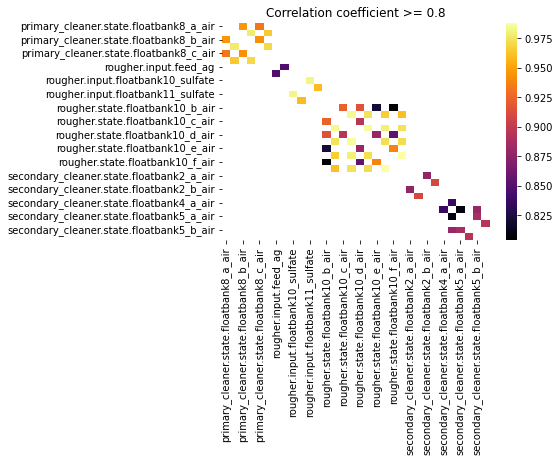

<Figure size 864x864 with 0 Axes>

In [33]:
correlation_train = correlation(df_train);

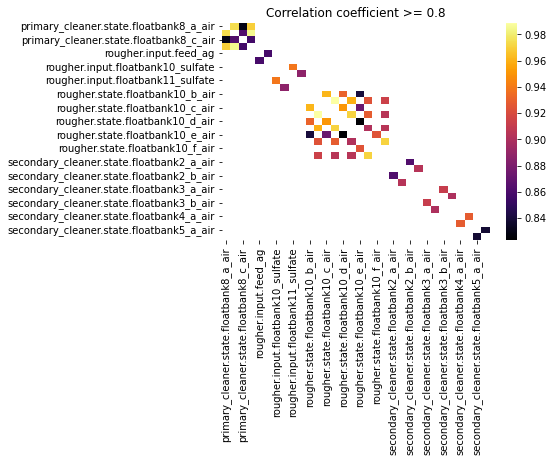

<Figure size 864x864 with 0 Axes>

In [34]:
correlation_test = correlation(df_test)

По heatmap становится видно, что наиболее сильно коррелирующие между собой признаки это параметры state внутри одного и того же этапа.
Вспомню, что state это параметры, характеризующие текущее состояние этапа.
Наличие таких корреляций вполне понятно, если флотационные установки несколько раз замеряют такие параметры как объем воздуха или уровень жидкости в каждой флотационной установке.

Это любопытная находка, во время обучения модели можно попробовать оставить только по одному параметру с идентичных этапов и посмотреть, как это повлияет на точность моделей. Например, из primary_cleaner.state.floatbank8 оставить только одну запись об объеме воздуха вместо трех.

Looking at the heatmap it becomes clear that the most strongly correlated features are the "state" parameters within the same stage.
The "state" parameters are the parameteres that characterize the current state of the stage.
The presence of such correlations is quite understandable if the flotation units measure parameters such as air volume or liquid level in each flotation unit several times.

This is an interesting finding, I might want to consider leaving only one of the correlated features during the model training process.

In [35]:
corr_train = pd.DataFrame(data = correlation_train)

In [36]:
corr_train.reset_index(inplace = True)

In [37]:
corr_train.columns = ['parameter_one', 'parameter_two', 'corr']

In [38]:
corr_test = pd.DataFrame(data = correlation_test)
corr_test.reset_index(inplace = True)
corr_test.columns = ['parameter_one', 'parameter_two', 'corr']

In [39]:
correlation_table = corr_train.merge(corr_test, how = 'outer', on = 'parameter_one')

In [40]:
correlation_table
correlation_table = correlation_table[['parameter_one',
                                       'parameter_two_x',
                                       'parameter_two_y',
                                       'corr_x',
                                       'corr_y']]

In [41]:
correlation_table

,parameter_one,parameter_two_x,parameter_two_y,corr_x,corr_y
0,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_level,rougher.state.floatbank10_c_level,0.987995,0.927396
1,rougher.state.floatbank10_e_level,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_level,0.965779,0.927396
2,rougher.state.floatbank10_d_level,rougher.state.floatbank10_c_level,rougher.state.floatbank10_c_level,0.986327,0.970847
3,rougher.state.floatbank10_d_level,rougher.state.floatbank10_c_level,rougher.state.floatbank10_b_level,0.986327,0.959528
4,rougher.state.floatbank10_d_level,rougher.state.floatbank10_c_level,rougher.state.floatbank10_e_level,0.986327,0.901394
5,rougher.state.floatbank10_d_level,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_level,0.973692,0.970847
6,rougher.state.floatbank10_d_level,rougher.state.floatbank10_b_level,rougher.state.floatbank10_b_level,0.973692,0.959528
7,rougher.state.floatbank10_d_level,rougher.state.floatbank10_b_level,rougher.state.floatbank10_e_level,0.973692,0.901394
8,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_level,rougher.state.floatbank10_c_level,0.972247,0.970847
9,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_level,rougher.state.floatbank10_b_level,0.972247,0.959528


In [42]:
df_train['primary_cleaner.state.floatbank8_d_air'].corr(df_train['primary_cleaner.state.floatbank8_c_air'])

0.3278106118221578

In [43]:
df_train['secondary_cleaner.state.floatbank3_a_level'].corr(df_train['secondary_cleaner.state.floatbank3_b_air'])

0.12805378380105537

In [44]:
df_train['secondary_cleaner.state.floatbank3_a_air'].corr(df_train['secondary_cleaner.state.floatbank3_b_level'])

-0.206940065503679

In [45]:
df_test['secondary_cleaner.state.floatbank5_a_level'].corr(df_test['secondary_cleaner.state.floatbank5_b_level'])

0.48970783389176764

In [46]:
correlated_parameteres_both_sets = ['rougher.state.floatbank10_a_level',
                                    'rougher.state.floatbank10_a_air'
                                   'primary_cleaner.state.floatbank8_a_level',
                                   'rougher.input.floatbank11_xanthate',
                                    'secondary_cleaner.state.floatbank2_a_level',
                                    'secondary_cleaner.state.floatbank2_a_air',
                                    'secondary_cleaner.state.floatbank5_a_air',
                                   ]

In [47]:
correlated_parameteres_train = ['primary_cleaner.state.floatbank8_d_air',
                                'secondary_cleaner.state.floatbank3_a_level',
                                'secondary_cleaner.state.floatbank3_a_air']

In [48]:
correlated_parameteres_test = ['secondary_cleaner.state.floatbank5_a_level']

Based on the correlation analysis I draw the following conclusions:

- Parameters stored in the correlated_parameteres_both_sets list correlate in both datasets with similar parameters. Thus, they can be left without problems and similar parameters can be removed (for example leave rougher.state.floatbank10_a_level but remove this parameter for b_level, c_level, etc.)
- Some parameters correlate only in the training set, but do not correlate in the test and vice versa. This can also affect the accuracy of the models. I think it makes sense to try to train the model using these features in the training set and without them and compare the accuracy of the resulting models.

# EDA

## The concentration of metals (Au, Ag, Pb) at different cleaning steps analysis

Let me remind myself that the extraction of gold occurs in 4 stages:

- rougher - flotation
- primary_cleaner - primary cleaning
- secondary_cleaner - secondary cleaning
- final - final characteristics

The metal concentration data is contained in the *input* and *output* parameters.

In [49]:
def concentration_check(df, metal, tail=False):
    if tail == False:
        product = 'concentrate_'
    else:
        product = 'tail_'

    metal_columns = [
        i for i in df.columns if
        (str('feed_'+metal) in i) or
        (str(product+metal) in i)
    ]

    metal_df = df[metal_columns]
    return metal_df

In [50]:
# Builds a metal concentration in ore bar chart
def concetration_plot(df, colors, labels, title):
    plt.hist(df, 
             bins = 10, 
             histtype='bar',
             stacked = 'True',
             alpha = 0.6,
             color=colors, 
             label=labels)
    plt.legend(prop={'size': 10})
    plt.title(title)
    plt.figure(figsize = (10, 10))

    plt.show()

### Gold Au concentration

In [51]:
au_concentrated = concentration_check(df_full, 'au', tail=False)

In [52]:
au_concentrated.head()

,final.output.concentrate_au,primary_cleaner.output.concentrate_au,rougher.input.feed_au,rougher.output.concentrate_au
0,42.192020,34.174427,6.486150,19.793808
1,42.701629,34.118526,6.478583,20.050975
2,42.657501,33.969464,6.362222,19.737170
3,42.689819,28.260743,6.118189,19.320810
4,42.774141,33.044932,5.663707,19.216101


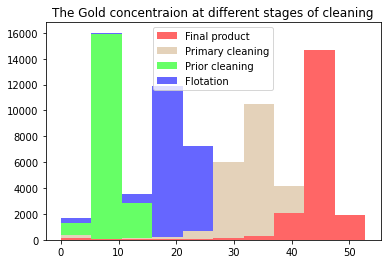

<Figure size 720x720 with 0 Axes>

In [53]:
colors = ['red', 'tan', 'lime', 'blue']
labels = ['Final product', 'Primary cleaning',
          'Prior cleaning', 'Flotation']
title = 'The Gold concentraion at different stages of cleaning'

concetration_plot(au_concentrated, colors=colors, labels=labels, title=title)

Looking at the chart we can see that the data contains anomalous zeros, which will need to be eliminated before models can be trained on this data.\

The only exception can be the data where the initial concentration was equal to zero.

In [54]:
au_concentrated[au_concentrated == 0].count()

final.output.concentrate_au               98
primary_cleaner.output.concentrate_au    108
rougher.input.feed_au                      0
rougher.output.concentrate_au            394
dtype: int64

All zeros appear during the processing of the ore, these data are anomalous and should be removed.

In [55]:
au_concentrated = au_concentrated.loc[(au_concentrated['rougher.output.concentrate_au'] != 0) &
                                      (au_concentrated['primary_cleaner.output.concentrate_au'] != 0) &

                                      (au_concentrated['final.output.concentrate_au'] != 0)]

In [56]:
au_concentrated[au_concentrated == 0].count()

final.output.concentrate_au              0
primary_cleaner.output.concentrate_au    0
rougher.input.feed_au                    0
rougher.output.concentrate_au            0
dtype: int64

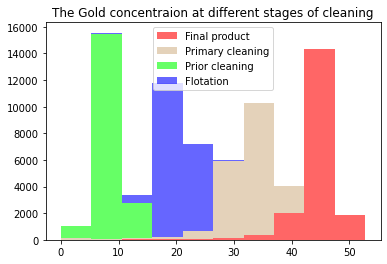

<Figure size 720x720 with 0 Axes>

In [57]:
colors = ['red', 'tan', 'lime', 'blue']
labels = ['Final product', 'Primary cleaning',
          'Prior cleaning', 'Flotation']
title = 'The Gold concentraion at different stages of cleaning'

concetration_plot(au_concentrated, colors=colors, labels=labels, title=title)

Much better now. Concentration of gold in the ore increases with each stage. 

In [58]:
df_full[au_concentrated.columns][df_full == 0].count()

final.output.concentrate_au               98
primary_cleaner.output.concentrate_au    108
rougher.input.feed_au                      0
rougher.output.concentrate_au            394
dtype: int64

In [59]:
df_full.shape

(19439, 87)

In [60]:
for i in au_concentrated.columns:
    df_full = df_full[df_full[i] != 0]

In [61]:
df_full.shape

(18848, 87)

### Concentration of Gold Au in waste tailings

In [62]:
au_tail = concentration_check(df_full, 'au', tail=True)

In [63]:
au_tail.head()

,final.output.tail_au,primary_cleaner.output.tail_au,rougher.input.feed_au,rougher.output.tail_au,secondary_cleaner.output.tail_au
0,2.143149,2.106679,6.486150,1.170244,2.606185
1,2.224930,2.353017,6.478583,1.184827,2.488248
2,2.257889,2.416800,6.362222,1.162562,2.458187
3,2.146849,2.262051,6.118189,1.079755,2.322062
4,2.055292,2.277073,5.663707,1.012642,2.330448


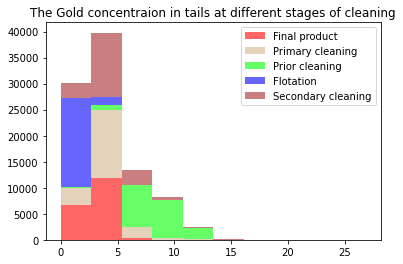

<Figure size 720x720 with 0 Axes>

In [64]:
colors = ['red', 'tan', 'lime', 'blue', 'brown']
labels = ['Final product', 'Primary cleaning',
          'Prior cleaning', 'Flotation', 'Secondary cleaning']
title = 'The Gold concentraion in tails at different stages of cleaning'

concetration_plot(au_tail, colors=colors, labels=labels, title=title)

The chart above shows that at different stages there is approximately the same proportion of gold in the tailings.

### Silver Ag concentration

In [65]:
ag_concentrated = concentration_check(df_full, 'ag', tail=False)

In [66]:
ag_concentrated.head()

,final.output.concentrate_ag,primary_cleaner.output.concentrate_ag,rougher.input.feed_ag,rougher.output.concentrate_ag
0,6.055403,8.547551,6.100378,11.500771
1,6.029369,8.558743,6.161113,11.615865
2,6.055926,8.603505,6.116455,11.695753
3,6.047977,7.221879,6.043309,11.915047
4,6.148599,9.089428,6.060915,12.411054


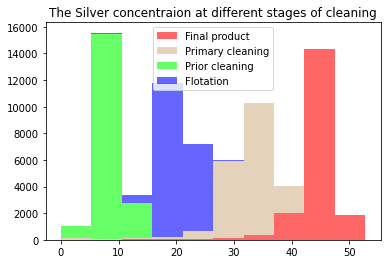

<Figure size 720x720 with 0 Axes>

In [67]:
colors = ['red', 'tan', 'lime', 'blue']
labels = ['Final product', 'Primary cleaning',
          'Prior cleaning', 'Flotation']
title = 'The Silver concentraion at different stages of cleaning'

concetration_plot(au_concentrated, colors=colors, labels=labels, title=title)

The graph shows that during flotation the proportion of silver in the ore increases.
You can also see that the proportion of silver in the crude concentrate during cleaning falls and in the final product drops down to zero.

In [68]:
ag_tail = concentration_check(df_full, 'ag', tail=True)

In [69]:
ag_tail.head()

,final.output.tail_ag,primary_cleaner.output.tail_ag,rougher.input.feed_ag,rougher.output.tail_ag,secondary_cleaner.output.tail_ag
0,10.411962,14.936526,6.100378,5.008018,14.500184
1,10.462676,16.250511,6.161113,4.955378,14.265474
2,10.507046,16.491823,6.116455,4.843460,14.115662
3,10.422762,16.024359,6.043309,4.655288,13.732071
4,10.360302,16.480185,6.060915,4.552800,14.079996


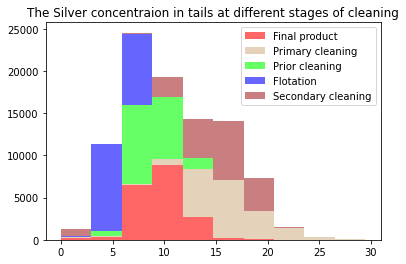

<Figure size 720x720 with 0 Axes>

In [70]:
colors = ['red', 'tan', 'lime', 'blue', 'brown']
labels = ['Final product', 'Primary cleaning',
          'Prior cleaning', 'Flotation', 'Secondary cleaning']
title = 'The Silver concentraion in tails at different stages of cleaning'

concetration_plot(ag_tail, colors=colors, labels=labels, title=title)

This graph is consistent with the earlier observations — during flotation little silver enters the final tailings.\
Most of the silver is washed out of the ore during primary and secondary treatment

### Lead Pb concentration

In [71]:
pb_concentrated = concentration_check(df_full, 'pb', tail=False)

In [72]:
pb_concentrated.head()

,final.output.concentrate_pb,primary_cleaner.output.concentrate_pb,rougher.input.feed_pb,rougher.output.concentrate_pb
0,9.889648,10.389648,2.284912,7.101074
1,9.968944,10.497069,2.266033,7.278807
2,10.213995,10.354494,2.159622,7.216833
3,9.977019,8.496563,2.037807,7.175616
4,10.142511,9.986786,1.786875,7.240205


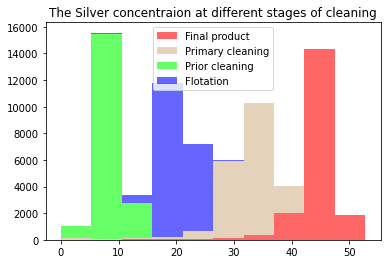

<Figure size 720x720 with 0 Axes>

In [73]:
colors = ['red', 'tan', 'lime', 'blue']
labels = ['Final product', 'Primary cleaning',
          'Prior cleaning', 'Flotation']
title = 'The Silver concentraion at different stages of cleaning'

concetration_plot(au_concentrated, colors=colors, labels=labels, title=title)

According to the chart I conclud that most of the lead is extracted from the ore during primary and secondary cleaning.\
In the flotation phase, however, lead remains in the ore as its proportion increases.

In [74]:
pb_tail = concentration_check(df_full, 'pb', tail=True)

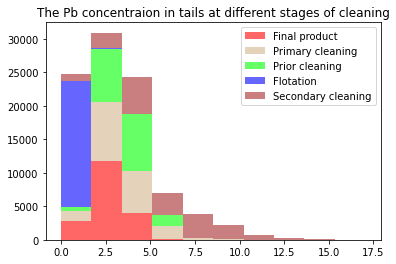

<Figure size 720x720 with 0 Axes>

In [75]:
colors = ['red', 'tan', 'lime', 'blue', 'brown']
labels = ['Final product', 'Primary cleaning',
          'Prior cleaning', 'Flotation', 'Secondary cleaning']
title = 'The Pb concentraion in tails at different stages of cleaning'

concetration_plot(pb_tail, colors=colors, labels=labels, title=title)

You can see that most of the lead is extracted from the ore during the secondary cleaning

### Results

During the analysis of the concentration of metals (Au, Ag, Pb) at various stages of cleaning I found some anomalous data with zero gold content in the ore at different stages of cleaning.

It has been observed that the level of silver and lead decreases in the concentrate during primary and secondary cleaning stages.

It can also be said that even without data on the concentration of metals in the concentrate after secondary treatment, one can rely on data on the proportion of metals in tailings in order to understand the change in shares at each of the stages.

## Size distributions of raw material granules on the training and test samples

In this section I compare the size distributions of raw material granules on the training and test samples.\
If the distributions are very different from each other, the estimation of the model will be wrong.

In [76]:
feed_size_columns = [i for i in df_full.columns if 'feed_size' in i]

In [77]:
feed_size_columns

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

Raw material granule size is measured during flotation and primary cleaning stages

In [78]:
feed_size_train = df_train[feed_size_columns]

In [79]:
feed_size_train.head()

,primary_cleaner.input.feed_size,rougher.input.feed_size
0,7.25,55.486599
1,7.25,57.278666
2,7.25,57.510649
3,7.25,57.792734
4,7.25,56.047189


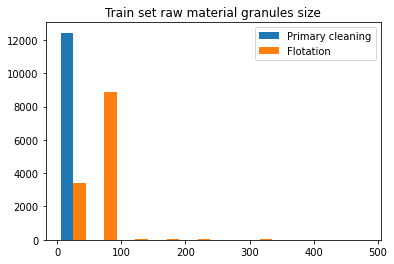

In [80]:
plt.hist(feed_size_train, label = ['Primary cleaning', 'Flotation'])
plt.legend(prop={'size': 10})
plt.title('Train set raw material granules size')
plt.show()

In [81]:
feed_size_train.describe()

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,12434.000000,12434.000000
mean,7.341663,58.525446
std,0.602813,20.586461
min,1.080000,9.659576
25%,6.980000,48.810718
50%,7.300000,54.769088
75%,7.700000,63.832312
max,10.470000,484.967466


You can see that the size of the raw material granules is much larger and varies more during flotation.

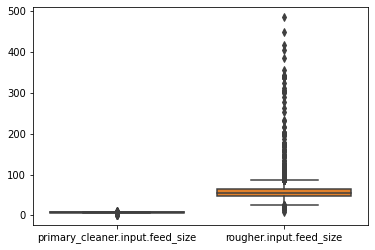

In [82]:
sns.boxplot(data=feed_size_train)
plt.show()

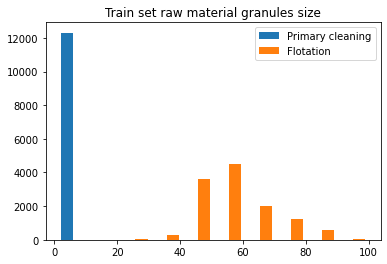

In [83]:
plt.hist(feed_size_train.query('`rougher.input.feed_size` < 100'), 
         label = ['Primary cleaning', 'Flotation'])
plt.legend(prop={'size': 10})
plt.title('Train set raw material granules size')
plt.show()

In [84]:
feed_size_test = df_test[feed_size_columns]

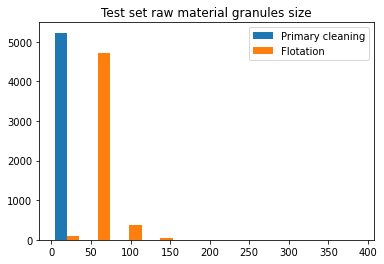

In [85]:
plt.hist(feed_size_test, label = ['Primary cleaning', 'Flotation'])
plt.legend(prop={'size': 10})
plt.title('Test set raw material granules size')
plt.show()

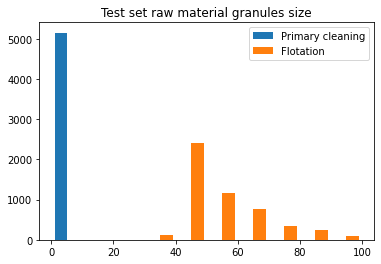

In [86]:
plt.hist(feed_size_test.query('`rougher.input.feed_size` < 100'), 
         label = ['Primary cleaning', 'Flotation'])
plt.legend(prop={'size': 10})
plt.title('Test set raw material granules size')
plt.show()

In [87]:
feed_size_test.describe()

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,5229.000000,5229.000000
mean,7.271546,55.863978
std,0.605887,18.914656
min,5.650000,0.046369
25%,6.900000,43.911874
50%,7.250000,50.772729
75%,7.600000,62.265394
max,15.500000,392.494040


In [88]:
feed_size_train.describe()

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,12434.000000,12434.000000
mean,7.341663,58.525446
std,0.602813,20.586461
min,1.080000,9.659576
25%,6.980000,48.810718
50%,7.300000,54.769088
75%,7.700000,63.832312
max,10.470000,484.967466


In [89]:
feed_size_comparison = pd.concat(
    [feed_size_train.describe(), feed_size_test.describe()], axis=1)
feed_size_comparison.columns = ['Train Primary cleaning',
                                'Train Flotation',
                                'Test Primary cleaning',
                                'Test Flotation']

In [90]:
print('Comparison of statistics on the size of granules in the train and test datasets')
feed_size_comparison

Comparison of statistics on the size of granules in the train and test datasets


,Train Primary cleaning,Train Flotation,Test Primary cleaning,Test Flotation
count,12434.000000,12434.000000,5229.000000,5229.000000
mean,7.341663,58.525446,7.271546,55.863978
std,0.602813,20.586461,0.605887,18.914656
min,1.080000,9.659576,5.650000,0.046369
25%,6.980000,48.810718,6.900000,43.911874
50%,7.300000,54.769088,7.250000,50.772729
75%,7.700000,63.832312,7.600000,62.265394
max,10.470000,484.967466,15.500000,392.494040


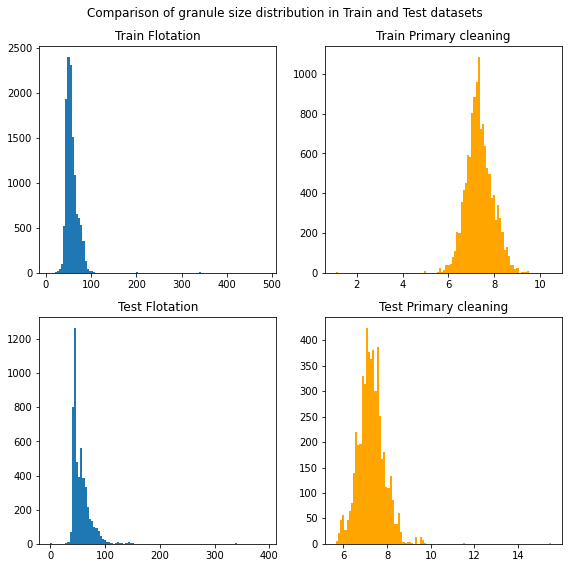

In [91]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.hist(feed_size_train.iloc[:,1], bins = 100)
ax1.set_title('Train Flotation')

ax2.hist(feed_size_train.iloc[:,0], bins = 100, color = 'orange')
ax2.set_title('Train Primary cleaning')

ax3.hist(feed_size_test.iloc[:,1], bins = 100)
ax3.set_title('Test Flotation')

ax4.hist(feed_size_test.iloc[:,0], bins = 100, color = 'orange')
ax4.set_title('Test Primary cleaning')

fig.suptitle('Comparison of granule size distribution in Train and Test datasets')
fig.tight_layout()
plt.show()

The table and graphs above show that:
1. The granule size data in the Flotation dataset contains outliers well above or below the 25% quartile.
2. The mean, standard deviation, and median are approximately the same in both datasets. Thus I can use this data to train the models.

In [92]:
Q1_train = feed_size_train.iloc[:, 1].quantile(0.25)
Q3_train = feed_size_train.iloc[:, 1].quantile(0.75)
IQR_train = Q3_train - Q1_train

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
feed_size_train_filtered = feed_size_train.query(
    '(@Q1_train - 1.5 * @IQR_train) <= `rougher.input.feed_size` <= (@Q3_train + 1.5 * @IQR_train)')

In [93]:
feed_size_train_filtered.shape

(12111, 2)

In [94]:
Q1_test = feed_size_test.iloc[:, 1].quantile(0.25)
Q3_test = feed_size_test.iloc[:, 1].quantile(0.75)
IQR_test = Q3_test - Q1_test

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
feed_size_test_filtered = feed_size_test.query(
    '(@Q1_test - 1.5 * @IQR_test) <= `rougher.input.feed_size` <= (@Q3_test + 1.5 * @IQR_test)')

In [95]:
feed_size_test_filtered.shape

(5050, 2)

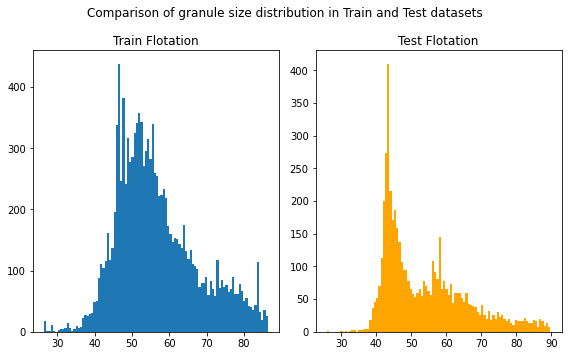

In [96]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.hist(feed_size_train_filtered.iloc[:,1], bins = 100)
ax1.set_title('Train Flotation')

ax2.hist(feed_size_test_filtered.iloc[:,1], bins = 100, color = 'orange')
ax2.set_title('Test Flotation')

fig.suptitle('Comparison of granule size distribution in Train and Test datasets')
fig.tight_layout()
plt.show()

In [97]:
pd.concat([feed_size_train_filtered.describe().iloc[:, 1],
           feed_size_test_filtered.describe().iloc[:, 1]], axis=1)

,rougher.input.feed_size,rougher.input.feed_size
count,12111.000000,5050.000000
mean,56.685013,53.779607
std,10.935346,11.933009
min,26.518583,25.891540
25%,48.696306,43.811271
50%,54.479037,49.899960
75%,62.948062,60.733305
max,86.362554,89.731322


The distribution remains the same after the outliers are removed.

However after the research it appeared that the outliers lie whithin normal range 40 — 100 mkm.\
Data about flotation process is available for example on this website: https://techade.ru/stati/flotatsiya-rudy

For this reason I won't consider the outliers as anomalies and will carry on with them.

## Analysis of the total concentration of all substances at different stages: in raw materials, in a rougher and final concentrates.

In [98]:
raw_concetration = [i for i in df_full.columns if 'rougher.input.feed' in i]

In [99]:
raw_concetration

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au']

In [100]:
raw_concetration.pop(2)
raw_concetration.pop(2)

'rougher.input.feed_size'

In [101]:
raw_concetration

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_au']

In [102]:
 df_full[raw_concetration].head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au
0,6.100378,2.284912,36.808594,6.486150
1,6.161113,2.266033,35.753385,6.478583
2,6.116455,2.159622,35.971630,6.362222
3,6.043309,2.037807,36.862241,6.118189
4,6.060915,1.786875,34.347666,5.663707


In [103]:
# summed concentration of all elements in the initial product before processing
raw_sum_concetration =  df_full[raw_concetration].sum(axis = 1)

In [104]:
raw_sum_concetration.head()

0    51.680034
1    50.659114
2    50.609929
3    51.061546
4    47.859163
dtype: float64

In [105]:
rougher_concetration = [i for i in df_full.columns if 'rougher.output.concentrate' in i]

In [106]:
rougher_concetration

['rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

In [107]:
rougher_sum_concetration =  df_full[rougher_concetration].sum(axis = 1)
print(rougher_sum_concetration.head())

0    66.424950
1    67.012710
2    66.103793
3    65.752751
4    65.908382
dtype: float64


In [108]:
final_concetration = [i for i in df_full.columns if 'final.output.concentrate' in i]

In [109]:
final_concetration

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au']

In [110]:
final_sum_concetration =  df_full[final_concetration].sum(axis = 1)
print(final_sum_concetration.head())

0    63.644396
1    63.957723
2    64.311180
3    63.573449
4    64.004667
dtype: float64


In [111]:
sum_concentration = pd.DataFrame({'Raw': raw_sum_concetration,
                                  'Rougher': rougher_sum_concetration, 
                                  'Final': final_sum_concetration})

In [112]:
sum_concentration.describe()

,Raw,Rougher,Final
count,18848.000000,18848.000000,18848.000000
mean,57.176955,69.564262,68.978387
std,7.604992,7.831388,5.587884
min,0.040000,0.040000,0.040000
25%,53.485430,66.327338,67.943798
50%,57.587786,70.313114,69.600444
75%,61.957959,74.445415,71.374700
max,76.978947,88.140119,80.210644


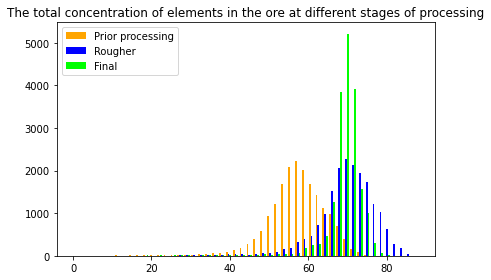

In [113]:
colors = ['orange', 'blue', 'lime']
labels = ['Prior processing', 'Rougher', 'Final']

fig, ax = plt.subplots(tight_layout=True)
ax.hist(sum_concentration, bins = 50, color=colors, label=labels)
ax.legend(prop={'size': 10})
ax.set_title('The total concentration of elements in the ore at different stages of processing')
plt.show()

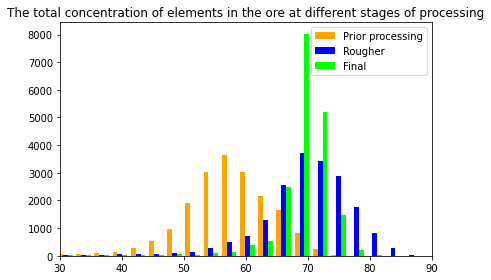

In [114]:
colors = ['orange', 'blue', 'lime']
labels = ['Prior processing', 'Rougher', 'Final']

fig, ax = plt.subplots(tight_layout=True)
ax.hist(sum_concentration, bins = 30, color=colors, label=labels)
ax.set_xlim([30,90])
ax.legend(prop={'size': 10})
ax.set_title('The total concentration of elements in the ore at different stages of processing')
plt.show()

According to the chart above I conclude that the concentration of substances in the ore increases before and after processing.
At the same time, it can be observed that in the crude concentrate the substances are less evenly distributed than in the final one (you can observe it both on the chart and looking at the high standard deviation).

This observation is consistent with the observations obtained in the previous steps - during the cleaning of the crude concentrate at different steps substances that are not gold are washed out of it, thus reducing the total proportion of substances in the ore.

# Model building

## Loss function sMAPE

For this project I will use sMAPE loss function.\
The formula is described in the function below.

In [115]:
def smape(a, f):
    # a -- actual value
    # f -- forecasted value
    return (1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100))

In [116]:
# scorer for cross validation
my_scorer = make_scorer(smape, greater_is_better = False)

I will also write a function for calculating the final sMAPE. It will take into account both the accuracy of predicting the enrichment of the rough concentrate and the final concentrate.

In [117]:
def total_smape(rougher_smape, final_smape):
    return (1/4 * abs(rougher_smape) + 3/4 * abs(final_smape))

Here I will store the results of the model training

In [118]:
smape_table = pd.DataFrame(columns = ['model', 'smape_rougher', 'smape_final', 'smape_total'])

## Model training

### Scaling the features

In [119]:
# random state
state = 1

In [120]:
y_rougher_train = df_train['rougher.output.recovery']
y_final_train = df_train['final.output.recovery']

X = df_train.drop('rougher.output.recovery', axis = 1)
X = df_train.drop('final.output.recovery', axis = 1)

In [121]:
X = df_train.drop('rougher.output.recovery', axis = 1)
X = X.drop('final.output.recovery', axis = 1)

print(y_rougher_train.shape)
print(y_final_train.shape)
print(X.shape)

(12434,)
(12434,)
(12434, 52)


In [122]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_scaled = pd.DataFrame(X_scaled)

X_scaled.columns = X.columns
X_scaled.index = X.index
X_scaled.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.265951,0.303027,-0.152064,0.277479,-0.431278,-0.313888,-0.421496,-0.808181,-0.423166,-0.290663,0.049300,-0.232786,-1.315185,-1.142309,0.454056,-0.147620,0.087069,-0.755421,0.055634,0.079371,0.013791,0.066983,-0.689634,-0.303863,1.626514,0.613528,1.484113,0.506562,1.953443,0.336792,1.762467,0.238998,2.253894,0.303679,-0.734245,-0.022943,-0.191188,-0.070004,-0.911443,-0.308858,-0.144204,-0.264847,-1.021904,-0.469530,-0.619103,-0.746581,-1.176363,-0.375916,-0.853180,-0.420250,-0.991784,-2.582799
1,-0.305436,0.353903,-0.152064,0.315757,-0.227177,-0.368709,-0.236385,-0.334540,-0.230039,-0.308878,0.120628,-0.351938,-1.282973,-1.159772,0.473463,-0.060566,-0.134156,-0.759518,0.050646,0.077226,0.064977,0.073291,-0.686122,-0.261926,1.613432,0.324717,1.474716,0.356741,1.961504,0.363177,1.733768,0.327837,2.155978,0.339004,-0.729260,-0.051158,-0.191889,-0.049454,-0.909890,-0.396593,-0.114993,-0.267296,-1.026221,-0.529077,-0.647481,-0.688915,-1.156789,-0.423515,-0.869721,-0.423037,-1.018975,-2.423878
2,-0.354278,0.662882,-0.152064,0.284379,-0.030820,-0.343753,-0.051882,-0.355788,-0.037732,-0.352554,0.209513,-0.371332,-1.306659,-1.258197,0.526158,-0.049296,-0.088401,-0.822520,0.034285,0.262039,0.040621,0.252079,-0.689557,-0.262019,1.605216,0.323673,1.470716,0.354308,1.958066,0.363167,1.733515,0.345868,2.159493,0.331085,-0.706599,-0.050000,-0.192377,-0.041095,-0.920009,-0.384893,0.261348,-0.277820,-1.022224,-0.470180,-0.654651,-0.685539,-1.151333,-0.422470,-0.864646,-0.421418,-1.013588,-2.466928
3,-0.396108,0.664657,-0.152064,0.299447,-0.043097,-0.369997,-0.049824,-0.329133,-0.050297,-0.348564,0.212734,-0.376206,-1.345453,-1.370870,0.665947,-0.035593,0.098316,-0.954648,-0.059664,0.267633,-0.032538,0.244579,-0.688980,-0.263341,1.609402,0.312085,1.472402,0.355172,1.947298,0.359704,1.743158,0.344078,2.159011,0.345371,-0.717999,-0.035482,-0.180679,-0.039045,-0.910549,-0.395198,0.260689,-0.278808,-1.018445,-0.437326,-0.638170,-0.686566,-1.168656,-0.398732,-0.871017,-0.414859,-1.017695,-2.429362
4,-0.511694,0.843821,-0.152064,0.335596,-0.032494,-0.315630,-0.043945,-0.347639,-0.055637,-0.353062,0.220536,-0.

## Random Forest

In [123]:
model = RandomForestRegressor(random_state = state)

parameters = { 'n_estimators': range (100, 501, 100),
              'max_depth': range (2,11, 2)}

grid = GridSearchCV(estimator = model, param_grid = parameters, verbose = 2, cv = 5, n_jobs = 4)
grid.fit(X_scaled, y_final_train)

print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'max_depth': 6, 'n_estimators': 200}


In [124]:
grid.best_params_
best_depth = grid.best_params_['max_depth']
best_n_estimators = grid.best_params_['n_estimators']

In [125]:
def total_smape_calculator(X, y_rougher, y_final, model=model, scorer=my_scorer):
    
    scores_rougher = cross_val_score(model, X, y_rougher, cv=5, scoring=my_scorer)
    print('The mean sMAPE for the gold concentration coefficient in tailings:', abs(scores_rougher.mean()))
    print()

    scores_final = cross_val_score(model, X, y_final, cv=5, scoring=my_scorer)
    print('The mean sMAPE for the gold concentration coefficient in final concentrate:', abs(scores_final.mean()))
    print()

    scores_combined = []
    for i in range(len(scores_rougher)):
        scores_combined.append(total_smape(scores_rougher[i], scores_final[i]))
        
    print('Total sMAPE', np.mean(scores_combined))
    
    return(abs(scores_rougher.mean()), abs(scores_final.mean()), np.mean(scores_combined))

In [126]:
model = RandomForestRegressor(
    max_depth=best_depth, n_estimators=best_n_estimators, random_state=state)

smape_rougher, smape_final, smape_total = total_smape_calculator(
    X_scaled, y_rougher_train, y_final_train, model=model)

The mean sMAPE for the gold concentration coefficient in tailings: 6.010105156232758

The mean sMAPE for the gold concentration coefficient in final concentrate: 8.808503457672234

Final sMAPE 8.108903882312365


In [127]:
def add_to_smape_table(model_name,
                       table = smape_table,
                       smape_rougher=smape_rougher,
                       smape_final=smape_final,
                       smape_total=smape_total):

    table = table.append({'model': model_name,
                          'smape_rougher': smape_rougher,
                          'smape_final': smape_final,
                          'smape_total': smape_total}, ignore_index=True)
    return table

In [128]:
smape_table = add_to_smape_table('RFR maximizing y_final', smape_table)

In [129]:
smape_table

,model,smape_rougher,smape_final,smape_total
0,RFR maximizing y_final,6.010105,8.808503,8.108904


In [130]:
def feature_importances(X, y, model=model):
    model.fit(X, y)

    # model is the trained model
    importances = model.feature_importances_

    # train_features is the dataframe of training features
    feature_list = list(X.columns)

    # Extract the feature importances into a dataframe
    feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

    # Show the top 10 most important
    feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
    return feature_results

In [131]:
def feature_importances_table(feature_importances_rougher, feature_importances_final):
    feature_importances_table = feature_importances_final.merge(feature_importances_rougher,
                                                                how='outer',
                                                                on='feature')
    feature_importances_table.columns = [
        'feature', 'importance_final', 'importance_rougher']

    feature_importances_table.plot(
        kind='barh', y=['importance_final', 'importance_rougher'], x='feature')
    plt.show()
    
    return feature_importances_table

In [132]:
feature_importances_rougher = feature_importances(X_scaled, y_rougher_train)

In [133]:
feature_importances_final = feature_importances(X_scaled, y_final_train)

In [134]:
feature_importances_rougher = feature_importances_rougher[:3]
feature_importances_final = feature_importances_final[:7]

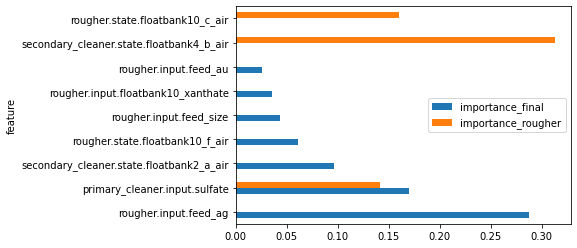

In [135]:
importance_table = feature_importances_table(feature_importances_rougher, feature_importances_final)

According to the the table above, the model only used 9 parameters for prediction with 2 being used exclusively for rough concentrate prediction and 6 for final concentrate prediction only. \
The only feature used to predict both values is the amount of sulfate fed into the primary cleaning. \
In this case, I can discard all unused parameters and try to make a prediction using the resulting model on the test dataset to improve model performance.

In [136]:
model = LinearRegression()
smape_rougher, smape_final, smape_total = total_smape_calculator(
    X_scaled, y_rougher_train, y_final_train, model=model)

The mean sMAPE for the gold concentration coefficient in tailings: 6.900936787564466

The mean sMAPE for the gold concentration coefficient in final concentrate: 10.210859648575124

Final sMAPE 9.38337893332246


In [137]:
smape_table = add_to_smape_table('LinearRegression',
                                 table = smape_table, 
                                 smape_rougher=smape_rougher,
                                 smape_final=smape_final,
                                 smape_total=smape_total)

In [138]:
smape_table

,model,smape_rougher,smape_final,smape_total
0,RFR maximizing y_final,6.010105,8.808503,8.108904
1,LinearRegression,6.900937,10.21086,9.383379


In [139]:
useful_features = list(importance_table['feature'])

In [140]:
X_cut = X_scaled[useful_features]

In [141]:
X_cut.shape

(12434, 9)

In [142]:
model_cut = RandomForestRegressor(
    max_depth=best_depth, n_estimators=best_n_estimators, random_state=state)

smape_rougher, smape_final, smape_total = total_smape_calculator(
    X_cut, y_rougher_train, y_final_train, model=model_cut)

The mean sMAPE for the gold concentration coefficient in tailings: 6.0328677242106385

The mean sMAPE for the gold concentration coefficient in final concentrate: 8.262782349055737

Final sMAPE 7.7053036928444625


In [143]:
smape_table = add_to_smape_table('RFR maximizing y_final with X_cut',
                                 table=smape_table,
                                 smape_rougher=smape_rougher,
                                 smape_final=smape_final,
                                 smape_total=smape_total)

In [144]:
smape_table

,model,smape_rougher,smape_final,smape_total
0,RFR maximizing y_final,6.010105,8.808503,8.108904
1,LinearRegression,6.900937,10.21086,9.383379
2,RFR maximizing y_final with X_cut,6.032868,8.262782,7.705304


## Separate models for predicting two targets

If in the previous step I found the best hyperparameters using gridsearch only for final.output.recovery (because the final metric is 75% dependent on it) now I will try to find hyperparameters specifically for the rougher.output.recovery prediction

In [148]:
model = RandomForestRegressor(random_state = state)

parameters = { 'n_estimators': range (200, 401, 100),
              'max_depth': range (2,9, 2)}

grid = GridSearchCV(estimator = model, 
                    param_grid = parameters, 
                    verbose = 0, 
                    cv = 5,
                    scoring=my_scorer)

grid.fit(X_scaled, y_rougher_train)

print(grid.best_params_)

{'max_depth': 6, 'n_estimators': 400}


In [150]:
grid.best_params_
best_depth_rougher = grid.best_params_['max_depth']
best_n_estimators_rougher = grid.best_params_['n_estimators']

In [151]:
model_rougher = RandomForestRegressor(
    max_depth=best_depth_rougher, n_estimators=best_n_estimators_rougher, random_state=state)

scores_rougher = cross_val_score(model_rougher, X_scaled, y_rougher_train, cv=5, scoring=my_scorer)
    
print('The mean sMAPE for the gold concentration coefficient in tailings', scores_rougher.mean())

The mean sMAPE for the gold concentration coefficient in tailings -6.002616820228921


In [153]:
model = RandomForestRegressor(random_state = state)

parameters = { 'n_estimators': range (200, 401, 100),
              'max_depth': range (2,9, 2)}

grid = GridSearchCV(estimator = model, 
                    param_grid = parameters, 
                    verbose = 0, 
                    cv = 5,
                    scoring=my_scorer)

grid.fit(X_scaled, y_final_train)

print(grid.best_params_)

{'max_depth': 6, 'n_estimators': 200}


In [154]:
grid.best_params_
best_depth_final = grid.best_params_['max_depth']
best_n_estimators_final = grid.best_params_['n_estimators']

In [155]:
model_final = RandomForestRegressor(
    max_depth=best_depth_final, n_estimators=best_n_estimators_final, random_state=state)

scores_final = cross_val_score(model_final, X_scaled, y_final_train, cv=5, scoring=my_scorer)
    
print('The mean sMAPE for the gold concentration coefficient in final concentrate', scores_final.mean())

The mean sMAPE for the gold concentration coefficient in tailings -8.808503457672234


In [156]:
smape_rougher = abs(scores_rougher)
smape_final = abs(scores_final)

smape_total = total_smape(smape_rougher, smape_final)

In [157]:
print('Total sMAPE:', smape_total.mean())

Final sMAPE: 8.107031798311407


In [158]:
smape_table = add_to_smape_table('RFR separate models',
                                 table = smape_table, 
                                 smape_rougher=smape_rougher.mean(),
                                 smape_final=smape_final.mean(),
                                 smape_total=smape_total.mean())

In [159]:
smape_table

,model,smape_rougher,smape_final,smape_total
0,RFR maximizing y_final,6.010105,8.808503,8.108904
1,LinearRegression,6.900937,10.21086,9.383379
2,RFR maximizing y_final with X_cut,6.032868,8.262782,7.705304
3,RFR separate models,6.002617,8.808503,8.107032


In [160]:
feature_importances_rougher = feature_importances(X_scaled, y_rougher_train, model = model_rougher)

In [161]:
feature_importances_final = feature_importances(X_scaled, y_final_train, model = model_final)

In [162]:
feature_importances_final.head(10)

,feature,importance
0,rougher.input.feed_ag,0.287699
1,primary_cleaner.input.sulfate,0.169873
2,secondary_cleaner.state.floatbank2_a_air,0.096640
3,rougher.state.floatbank10_f_air,0.060623
4,rougher.input.feed_size,0.043575
5,rougher.input.floatbank10_xanthate,0.035112
6,rougher.input.feed_au,0.025814
7,secondary_cleaner.state.floatbank3_a_air,0.019671
8,rougher.input.floatbank11_sulfate,0.018675
9,rougher.input.floatbank10_sulfate,0.018467


In [163]:
feature_importances_rougher.head(10)

,feature,importance
0,secondary_cleaner.state.floatbank4_b_air,0.312226
1,rougher.state.floatbank10_c_air,0.158641
2,primary_cleaner.input.sulfate,0.142600
3,rougher.input.feed_au,0.064072
4,rougher.input.feed_ag,0.055770
5,secondary_cleaner.state.floatbank5_a_air,0.029114
6,secondary_cleaner.state.floatbank6_a_air,0.029024
7,rougher.input.feed_sol,0.027886
8,secondary_cleaner.state.floatbank5_b_air,0.015599
9,primary_cleaner.input.depressant,0.013175


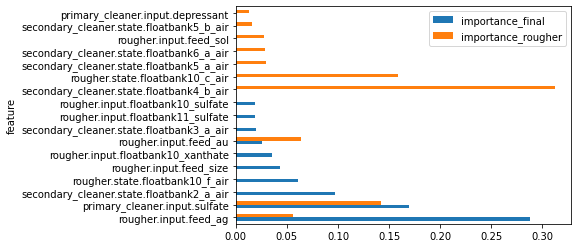

,feature,importance_final,importance_rougher
0,rougher.input.feed_ag,0.287699,0.055770
1,primary_cleaner.input.sulfate,0.169873,0.142600
2,secondary_cleaner.state.floatbank2_a_air,0.096640,NaN
3,rougher.state.floatbank10_f_air,0.060623,NaN
4,rougher.input.feed_size,0.043575,NaN
5,rougher.input.floatbank10_xanthate,0.035112,NaN
6,rougher.input.feed_au,0.025814,0.064072
7,secondary_cleaner.state.floatbank3_a_air,0.019671,NaN
8,rougher.input.floatbank11_sulfate,0.018675,NaN
9,rougher.input.floatbank10_sulfate,0.018467,NaN


In [164]:
feature_importances_table(feature_importances_rougher[:10], feature_importances_final[:10])

Let's combine the best models obtained in the previous steps for the final_output and the rougher_output prediction.

In [165]:
model_final = RandomForestRegressor(
    max_depth=6, n_estimators=200, random_state=state)

scores_final = cross_val_score(model_final, X_cut, y_final_train, cv=5, scoring=my_scorer)
    
print('The mean sMAPE for the gold concentration coefficient in final concentrate', scores_final.mean())

The mean sMAPE for the gold concentration coefficient in final concentrate -8.262782349055737


In [166]:
model_rougher = RandomForestRegressor(
    max_depth=6, n_estimators=400, random_state=state)

scores_rougher = cross_val_score(model_rougher, X_scaled, y_rougher_train, cv=5, scoring=my_scorer)
    
print('The mean sMAPE for the gold concentration coefficient in tailings', scores_rougher.mean())

The mean sMAPE for the gold concentration coefficient in tailings -6.002616820228921


In [167]:
scores_total = total_smape(scores_rougher, scores_final)
print('Total sMAPE:', scores_total.mean())

Total sMAPE: 7.697740966849034


In [168]:
smape_table = add_to_smape_table('RFR combined model',
                                 table = smape_table, 
                                 smape_rougher=scores_rougher.mean(),
                                 smape_final=scores_final.mean(),
                                 smape_total=scores_total.mean())

In [169]:
smape_table.sort_values(by='smape_total', ascending=True)

,model,smape_rougher,smape_final,smape_total
4,RFR combined model,-6.002617,-8.262782,7.697741
2,RFR maximizing y_final with X_cut,6.032868,8.262782,7.705304
3,RFR separate models,6.002617,8.808503,8.107032
0,RFR maximizing y_final,6.010105,8.808503,8.108904
1,LinearRegression,6.900937,10.21086,9.383379


The combined model showed the best results!

# Testing the models

The moment of truth. But first let's make sure that the test data set is pre-processed and the features are scaled 

In [170]:
df_test_1 = pd.read_csv('C:/datasets/gold_recovery_test_new.csv', index_col='date', parse_dates=True)
df_full_1 = pd.read_csv('C:/datasets/gold_recovery_full_new.csv', index_col='date', parse_dates=True)

In [171]:
features_1 = df_test_1.columns.values # selecting the columns
targets_1 = ['rougher.output.recovery', 'final.output.recovery'] # selecting targets

In [172]:
print(df_test_1.shape)
df_test_1 = df_test_1.dropna()
print(df_test_1.shape)

(5290, 52)
(5229, 52)


In [173]:
features_test_1 = df_test_1[features_1].reset_index(drop=True)
target_test_1 = df_full_1[targets_1].loc[df_test_1.index].reset_index(drop=True)

In [174]:
target_test_1.isna().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

In [175]:
target_test_1 = target_test_1.dropna()
target_test_1[target_test_1==0].sum()

rougher.output.recovery    0.0
final.output.recovery      0.0
dtype: float64

In [176]:
features_test_1.shape

(5229, 52)

In [177]:
target_test_1.shape

(5229, 2)

In [178]:
features_test_1 = features_test_1.loc[target_test_1.index]

In [179]:
features_test_1.shape

(5229, 52)

In [180]:
features_test_1 = features_test_1.reset_index(drop=True)
target_test_1 = target_test_1.reset_index(drop=True)

In [181]:
y_rougher_test = target_test_1['rougher.output.recovery']
y_final_test = target_test_1['final.output.recovery']

In [182]:
X_test = features_test_1

In [183]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

X_test_scaled = pd.DataFrame(X_test_scaled)

X_test_scaled.columns = X_test.columns
X_test_scaled.index = X_test.index
X_test_scaled.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0.836516,2.077780,1.334460,-0.602722,-1.268261,-0.135670,-1.246938,0.000331,-1.101158,-0.114207,-1.242086,0.027396,1.951933,1.926097,-0.020884,0.362001,0.787640,1.701551,0.913223,-0.324751,0.929131,-0.435543,-0.433283,0.501079,-0.456928,1.670117,-0.314754,1.645540,-0.099269,1.602340,-0.448555,1.171536,-0.389531,1.185756,-0.412534,0.074734,-1.634367,0.052407,-0.842762,1.226902,-1.054053,1.313766,-1.240361,0.234176,-1.685180,-0.449936,-1.619895,4.202391,-1.761313,-0.133831,2.069979,0.049904
1,0.946387,2.075911,1.334460,-0.625430,-1.270090,-0.126390,-1.256189,0.005074,-1.134888,-0.041976,-1.237816,-0.003696,1.903858,1.809929,-0.017915,0.322383,0.633805,1.598813,0.937286,-0.475606,0.970730,-0.608731,-0.459844,0.499713,-0.465625,1.651683,-0.316146,1.640426,-0.087232,1.592793,-0.444479,1.172203,-0.384539,1.060694,-0.416890,0.098867,-1.638255,0.030233,-0.847361,1.233017,-1.038230,1.308449,-1.230387,0.204649,-1.651613,-0.430190,-1.616015,-1.509690,-1.759096,-0.137529,1.696840,0.047058
2,0.943216,1.380135,0.850275,-0.616732,-1.272647,-0.171146,-1.249353,0.005532,-1.118461,-0.185597,-1.237908,0.019705,1.957061,1.705458,-0.022562,0.583721,0.884205,1.706049,0.934261,-0.620575,0.966210,-0.782300,-0.461307,0.506763,-0.471806,1.644686,-0.323858,1.608884,-0.091227,1.574951,-0.445068,1.176502,-0.383590,1.141636,-0.421245,0.081398,-1.623004,0.023457,-0.839425,1.229783,-1.040486,1.317749,-1.258007,0.202296,-1.661621,-0.444427,-1.578638,0.019568,-1.749906,-0.127647,1.691290,0.026285
3,0.945042,1.089542,0.608182,-0.823538,-1.262532,-0.060499,-1.261412,0.024078,-1.100934,0.001647,-1.224687,-0.024479,1.572666,1.378093,-0.146719,0.211599,0.610264,1.762210,0.795187,-0.668143,0.815142,-0.840580,-0.446508,0.502492,-0.446672,1.680059,-0.310370,1.637893,-0.093242,1.644108,-0.429646,1.156223,-0.380322,1.159086,-0.425601,0.114252,-1.641554,0.056884,-0.840757,1.249096,-1.050033,1.320881,-1.237611,0.215963,-1.668065,-0.428283,-1.636291,0.015485,-1.740716,-0.131646,1.681121,0.075755
4,0.556509,0.651310,0.426613,-0.913950,-1.247690,-0.167832,-1.255565,0.014243,-1.083498,-0.119448,-1.238048,0.031106,1.013671,1.013379,-0.03

In [184]:
X_test_cut = X_test_scaled[useful_features]
X_test_cut.shape

(5229, 9)

All right, the test set is ready

In [185]:
model = model_rougher
model.fit(X_scaled, y_rougher_train)

predictions_rougher_test = model.predict(X_test_scaled)

score_rougher_test = smape(np.array(y_rougher_test), np.array(predictions_rougher_test))
print('sMAPE for the tailings is:', score_rougher_test)

sMAPE for the tailings is: 8.8000197573672


In [186]:
model = model_final
model.fit(X_cut, y_final_train)

predictions_final_test = model.predict(X_test_cut)

score_final_test = smape(np.array(y_final_test), np.array(predictions_final_test))
print('sMAPE for the final contrate:', score_final_test)

sMAPE for the final contrate: 10.151905330102108


In [187]:
score_total_test = total_smape(score_rougher_test, score_final_test)
print('Total sMAPE:', score_total_test)

Total sMAPE: 9.813933936918382


In [188]:
smape_table = add_to_smape_table('RFR combined model test check',
                                 table = smape_table, 
                                 smape_rougher=score_rougher_test,
                                 smape_final=score_final_test,
                                 smape_total=score_total_test)

In [202]:
smape_table

,model,smape_rougher,smape_final,smape_total
0,RFR maximizing y_final,6.010105,8.808503,8.108904
1,LinearRegression,6.900937,10.21086,9.383379
2,RFR maximizing y_final with X_cut,6.032868,8.262782,7.705304
3,RFR separate models,6.002617,8.808503,8.107032
4,RFR combined model,-6.002617,-8.262782,7.697741
5,RFR combined model test check,8.80002,10.151905,9.813934


# Results

In the course of the work, a Random Forest Regressor model was built with parameters selected using gridsearchcv and trained on 9 features.

The model showed a total sMAPE result of ~9.8 on a test set, apperantly overfitting on the training data.

In future iterations o